
<i><b>Public-AI</b></i>
### week 5. 특성데이터(feature)와 Factorization Machine

# Section 1. Multi Armed Bandit



In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import beta
from tensorflow.keras.utils import get_file

import matplotlib.pyplot as plt

# [ 문제 상황 : 어떤 추천 모형으로 고객에게 제공했을 때 클릭이 가장 많이 일어날까? ]
---

## 예제) 모형에 따라, 고객의 클릭 유무를 알려주는 클래스

<img src="https://imgur.com/3CSk6B5.png" width="500" > 

우리에게는 3가지 추천 모형이 있습니다. 세 추천 모형 모두 고객이 관심가질만한 제품을 노출시켜, 클릭을 유도하기 위해 설계되어 있습니다. 즉 높은 클릭율(CTR)일수록 좋은 모형입니다. 하지만 우리는 셋 중 어느 모형이 높은 CTR을 보일지 모릅니다. 이 때 우리는 어떻게 시도하는 것이 좋을까요?

In [2]:
class Simulator:
    fpath = get_file(
        'MAB_simulation.csv',
        'https://pai-datasets.s3.ap-northeast-2.amazonaws.com/alai-deeplearning/MAB_simulation.csv')
    ads_df = pd.read_csv(fpath)
    def __init__(self):
        self.idx = 0
        self.model_list = ['TOP_K','CF','BPR']
        
    def recommend_by(self, model_name):
        assert model_name in self.model_list
        self.idx += 1
        idx = self.idx % 10000
        return bool(self.ads_df.loc[self.idx,model_name])

### 평가할 3가지 모형

* `Top-K` : 상위 K개의 아이템 노출
* `CF` : Item-Based Collaborative Filtering을 통한 아이템 노출
* `BPR` : Bayesian Personalized Ranking을 통한 아이템 노출

In [3]:
simulator = Simulator()
simulator.model_list

['TOP_K', 'CF', 'BPR']

### Case 1) Top-K을 이용해 추천했을 때의 결과



In [4]:
for i in range(10):
    result = simulator.recommend_by('TOP_K')
    print("{}th 시도 : {}".format(i, result))

0th 시도 : False
1th 시도 : False
2th 시도 : False
3th 시도 : False
4th 시도 : False
5th 시도 : False
6th 시도 : False
7th 시도 : False
8th 시도 : True
9th 시도 : False


### Case 2) CF을 이용해 추천했을 때의 결과

In [5]:
for i in range(10):
    result = simulator.recommend_by('CF')
    print("{}th 시도 : {}".format(i, result))

0th 시도 : False
1th 시도 : False
2th 시도 : False
3th 시도 : True
4th 시도 : True
5th 시도 : False
6th 시도 : False
7th 시도 : True
8th 시도 : False
9th 시도 : True


In [6]:
cf_click = 0
for i in range(1000):
    cf_click += simulator.recommend_by('CF')
cf_click/1000

0.209

### Case 3) BPR을 이용해 추천했을 때의 결과

In [7]:
for i in range(10):
    result = simulator.recommend_by('CF')
    print("{}th 시도 : {}".format(i, result))

0th 시도 : False
1th 시도 : False
2th 시도 : False
3th 시도 : False
4th 시도 : True
5th 시도 : True
6th 시도 : False
7th 시도 : False
8th 시도 : True
9th 시도 : True


### CTR을 알아내는 방법, 빈도 기반 확률 계산

각각 모델 별로 1000번씩 돌린다고 해봅시다.

In [8]:
topk_click = 0
for i in range(1000):
    topk_click += simulator.recommend_by('TOP_K')
topk_click/1000

0.074

In [9]:
cf_click = 0
for i in range(1000):
    cf_click += simulator.recommend_by('CF')
cf_click/1000

0.228

In [10]:
bpr_click = 0
for i in range(1000):
    bpr_click += simulator.recommend_by('BPR')
bpr_click/1000

0.291

우리는 총 3000번의 시도를 통해, BPR 알고리즘의 CTR이 가장 높다는 것을 추론해냈습니다. 우리가 처음부터 BPR 알고리즘이 CTR이 가장 높았다는 것을 알았더라면, 800여번을 클릭 횟수를 이루어냈을텐데, 실험하는 과정에서 top_k와 CF 알고리즘으로 인해, 500여번의 훨씬 적은 클릭 횟수를 기록했습니다. 즉 우리는 300여번의 클릭을 놓친 셈이 됩니다. 이러한 것들은 기업의 입장에서는 모두 비용에 해당하게 됩니다. 어떻게 우리는 적은 시도 횟수로도 클릭을 이끌어낼 수 있을까요?

# [ Multi Armed Bandit을 푸는 알고리즘 , Thompson Sampling ]
---

## Thompson Sampling 알고리즘

### Beta 분포란?

베타 분포는 $\alpha$와 $\beta$라는 두 모수를 가지며 표본 공간은 0과 1 사이의 실수인 분포입니다.

$$
Beta(x;\alpha,\beta) = \frac{1}{B(\alpha,\beta)}x^{(\alpha-1)}(1-x)^{(\beta-1)}
$$

Beta 분포는 모수 $\alpha$,$\beta$를 통해 기댓값, 분산, 최빈값을 쉽게 추론할 수 있습니다.

* 기댓값 : $E[x] = \frac{\alpha}{\alpha+\beta}$
* 분산 : $Var[x] = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$
* 최빈값 : $Mode[x] = \frac{\alpha-1}{\alpha+\beta-2}$

### Beta 분포를 통해 우리가 알 수 있는 것 -> 확률에 대한 확신 수준

10번 중 2번 고객이 클릭했을 때와 100번 중 20번 고객이 클릭했을 때 모두 CTR은 20%입니다. 그런데 10번을 했을 때 측정된 CTR이 믿을만할까요, 100번을 시도했을 때 측정된 CTR이 믿을만할까요? 베타 분포는 확신의 정도를 분포를 통해 보여줍니다.

#### case 1) 고객에게 10번 노출시켰을 때, 2번 클릭한 경우

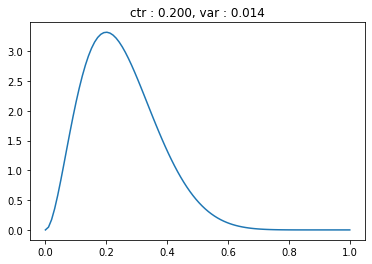

In [11]:
from scipy.stats import beta 

click = 2
total = 10

a = click + 1
b = total - click + 1

xs = np.linspace(0+1e-5,1-1e-5,100)
ys = beta.pdf(xs, a, b)

ctr = (a-1)/(a+b-2)
var = (a*b)/((a+b)**2*(a+b+1))

plt.title("ctr : {:.3f}, var : {:.3f}".format(ctr,var))
plt.plot(xs,ys)
plt.show()

#### Case 2) 고객에게 100번 노출시켰을 때, 20번 클릭한 경우

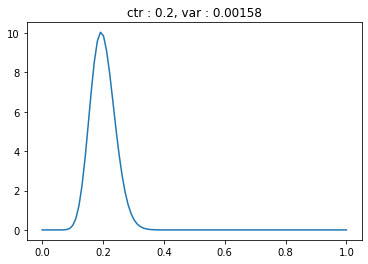

In [12]:
from scipy.stats import beta 

click = 20
total = 100

a = click
b = total - click

xs = np.linspace(0+1e-5,1-1e-5,100)
ys = beta.pdf(xs, a, b)

ctr = a/(a+b)
var = (a*b)/((a+b)**2*(a+b+1))

plt.title("ctr : {:.1f}, var : {:.5f}".format(ctr,var))
plt.plot(xs,ys)
plt.show()

#### Case 3) 고객에게 1000번 노출시켰을 때, 200번 클릭한 경우

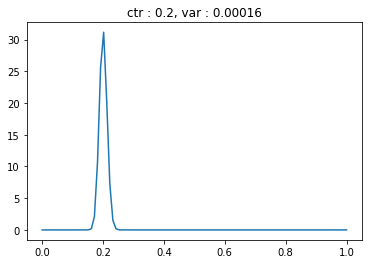

In [13]:
from scipy.stats import beta 

click = 200
total = 1000

a = 1 + click
b = 1 + total - click

xs = np.linspace(0+1e-5,1-1e-5,100)
ys = beta.pdf(xs, a, b)

ctr = a/(a+b)
var = (a*b)/((a+b)**2*(a+b+1))

plt.title("ctr : {:.1f}, var : {:.5f}".format(ctr,var))
plt.plot(xs,ys)
plt.show()

### Thompson Sampling을 통한 CTR 추정하기

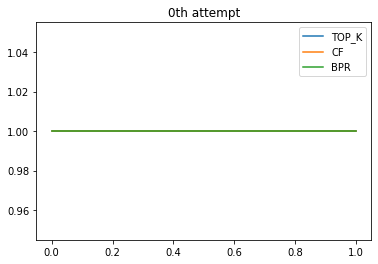

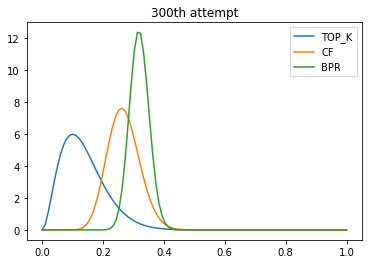

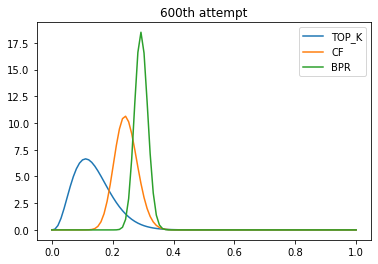

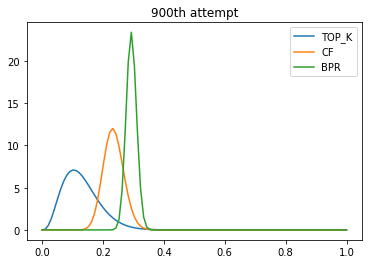

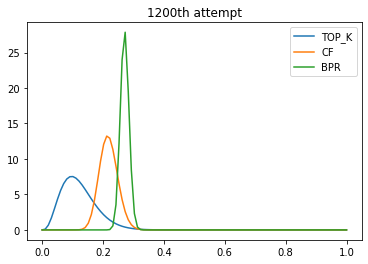

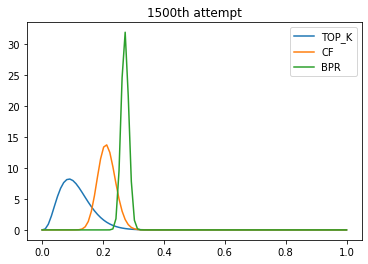

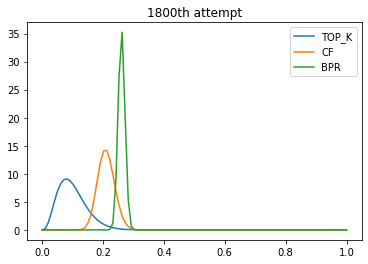

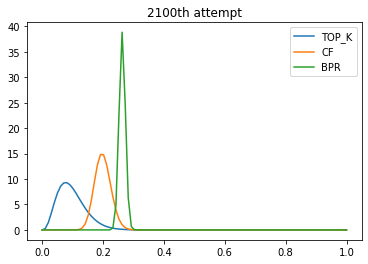

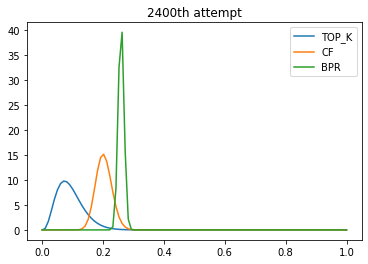

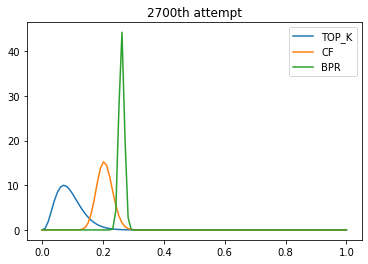

In [14]:
arms = pd.DataFrame(np.ones((3,2)), 
                    columns=['alpha','beta'],
                    index=['TOP_K','CF','BPR'])

clicks = 0
for idx in range(3000):
    # Visualization
    if idx % 300 == 0:
        for name, row in arms.iterrows():
            xs = np.linspace(0+1e-5,1-1e-5,100)
            ys = beta.pdf(xs, row.alpha, row.beta)

            plt.plot(xs,ys,label=name)
        plt.title(f'{idx}th attempt')
        plt.legend()
        plt.show()
        
    # Sampling Model
    bandit_result = { name : np.random.beta(row.alpha, row.beta) 
                     for name, row in arms.iterrows()}
    
    # Select 
    chosen_model = pd.Series(bandit_result).idxmax()    
    
    # Update Distribution
    click = simulator.recommend_by(chosen_model)
    clicks += click
    if click:
        # Success
        arms.loc[chosen_model,'alpha'] += 1
    else:
        arms.loc[chosen_model,'beta'] += 1        

### Thompson Sampling을 통한 CTR 예측값

In [15]:
( arms.alpha-1 )/ (arms.alpha + arms.beta - 2)

TOP_K    0.071429
CF       0.199170
BPR      0.259845
dtype: float64